In [276]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format

from statsmodels.graphics.tsaplots import plot_acf
from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from test_normal import *
from time_series import *
from cross_validation import *


warnings.filterwarnings("ignore")

Datensatz lesen

In [277]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [278]:
# Filtern nach Store
store_number = 10
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

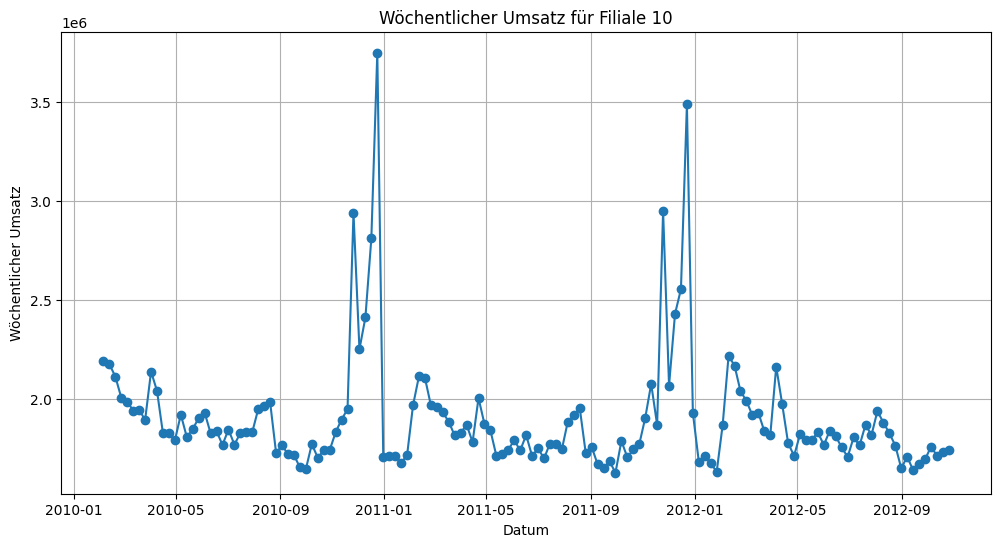

In [279]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Wöchentlicher Umsatz für Filiale {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.grid(True)
plt.show()

Seasonal

In [280]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

Modell wählen

In [281]:
model_type = 'SARIMA'
#model_type = 'Naive'

Residuen und Fitted Values berechnen

In [282]:
if model_type == 'Naive':
    resid, fitted_values = build_naive_model(sales)

if model_type == 'SARIMA':
    sarima_params  = optimal_orders_5.get(str(store_number))
    order = tuple(sarima_params["order"])
    seasonal_order = tuple(sarima_params["seasonal_order"])

    sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
    resid = sarima_model.resid.iloc[1:]
    fitted_values = sarima_model.fittedvalues.iloc[1:]
    sarima_model.summary()

Plot

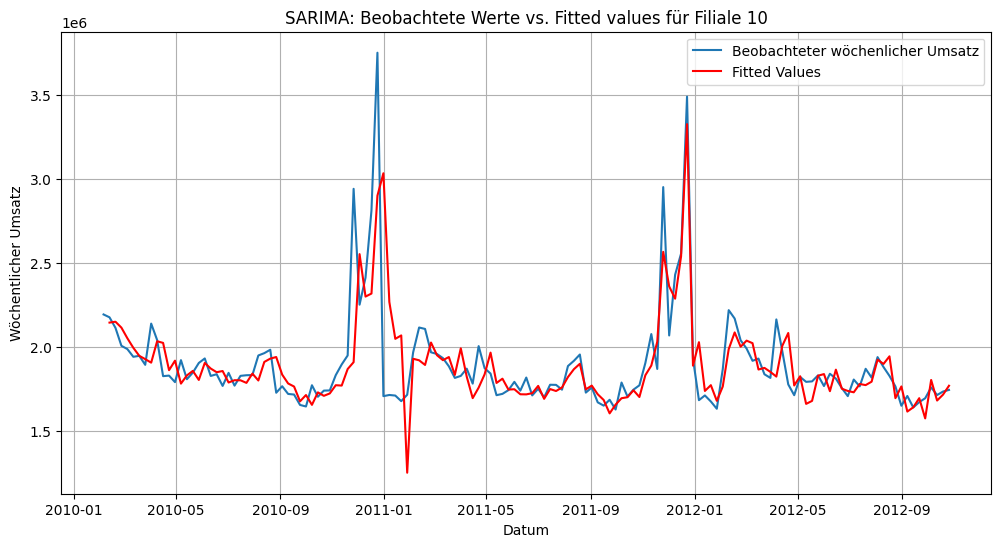

In [283]:
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.title('SARIMA: Beobachtete Werte vs. Fitted values für Filiale {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()


In [284]:
pd.set_option('display.max_rows', None)
non_nan_count = resid.count()
print(non_nan_count)
print(resid)

142
date
2010-02-12      31441.07
2010-02-19     -36435.55
2010-02-26    -107855.99
2010-03-05     -64451.77
2010-03-12     -53455.97
2010-03-19       -133.20
2010-03-26     -33966.86
2010-04-02     232210.57
2010-04-09       7439.56
2010-04-16    -197709.25
2010-04-23     -32216.36
2010-04-30    -127577.09
2010-05-07     139587.41
2010-05-14     -22548.69
2010-05-21      -9950.10
2010-05-28     100940.12
2010-06-04      26861.25
2010-06-11     -43936.00
2010-06-18     -11980.66
2010-06-25     -88575.65
2010-07-02      57495.18
2010-07-09     -32344.66
2010-07-16      26448.14
2010-07-23      45495.51
2010-07-30      -8787.89
2010-08-06     148838.07
2010-08-13      52304.16
2010-08-20      52768.56
2010-08-27    -212391.54
2010-09-03     -69110.63
2010-09-10     -62191.62
2010-09-17     -47659.81
2010-09-24     -21463.15
2010-10-01     -68074.48
2010-10-08     116604.71
2010-10-15     -25982.28
2010-10-22      31081.15
2010-10-29      17757.28
2010-11-05      59951.73
2010-11-12     1

Korrelations Tests

Box Pierce Test: 0.8206
Ljung Box Test: 0.7454
Monti Test: 0.1002
Fisher Test: 0.9704
Fisher Test: 0.5036
Pena Rodriguez (m=29, N=1000): 0.2248
Breusch Godfrey: 0.9998
Run Test: 0.1954
Durbin Watson: 2.0424


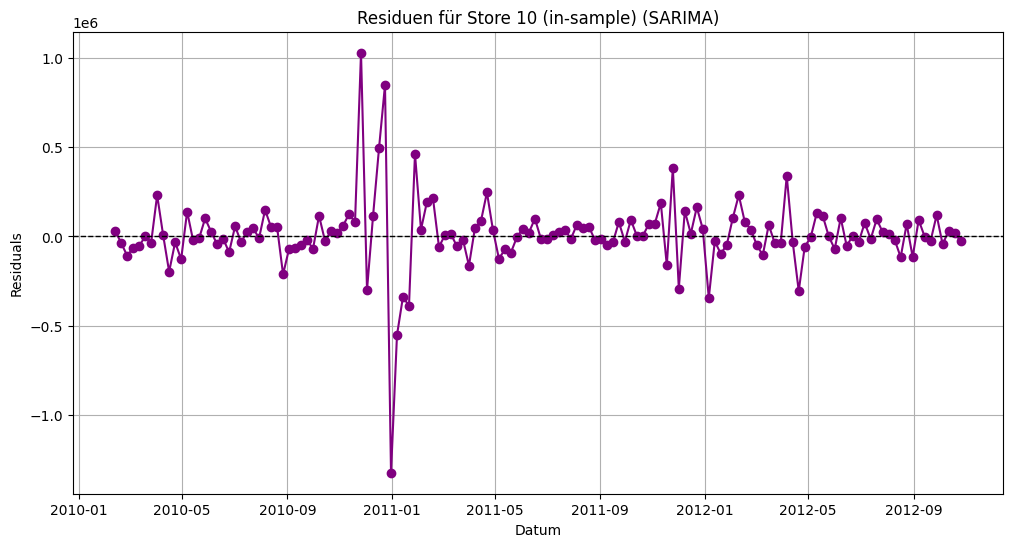

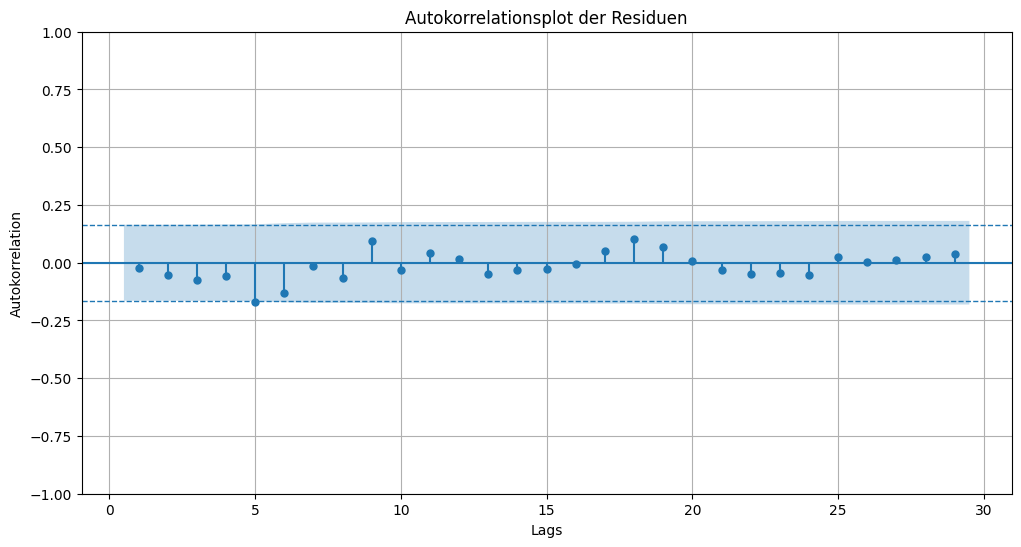

In [285]:
box_pierce_test(residuals = resid, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = resid, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = resid, store_num = store_number, model = model_type, m = 29)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "acf", m = 29)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "pacf", m = 29)
pena_rodriguez_test_mc(residuals = resid)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29)
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)

run_test(residuals = resid)
durbin_watson_test(residuals = resid)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(resid, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (in-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

#ACF Plot
acf_resid_plot(resid, lags = 29)



Mittelwert Tests

Mittelwert der Residuen: 10250.3353
T-Test: 0.5597
Wilcoxon Test: 0.3100
Binomial Test: 0.8013
Kolmogorov Test: 0.0000


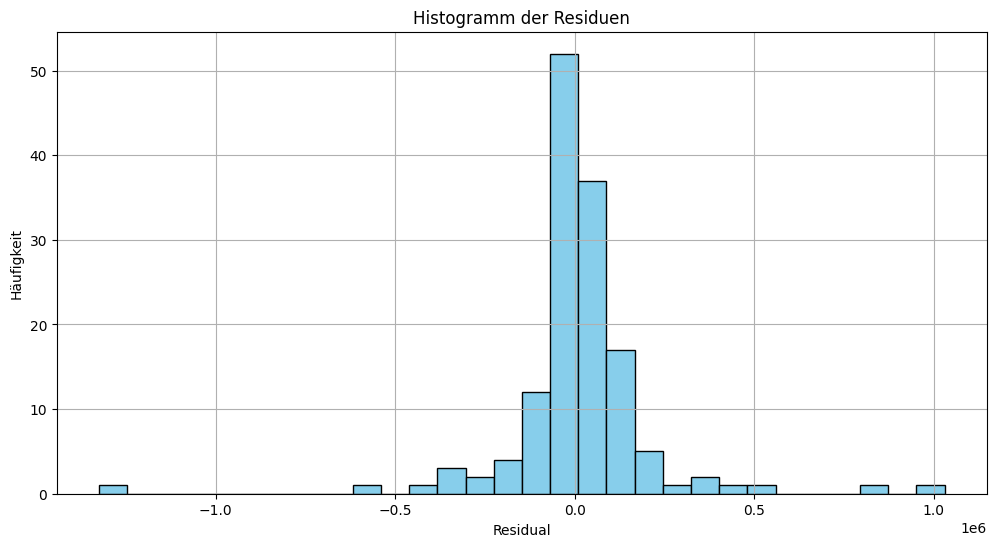

In [286]:
print(f"Mittelwert der Residuen: {resid.mean():.4f}")


t_test(resid)
wilcoxon_test(resid)
binomial_test(resid)
kolmogorov_test(resid)

hist_plot(resid)


SMAPE

In [287]:
numerator = np.abs(fitted_values - sales.iloc[1:])
denominator = (np.abs(fitted_values) + np.abs(sales.iloc[1:])) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 5.47%


Kreuz Validierung

Cross-Validation RMSE: 138974.18655925925


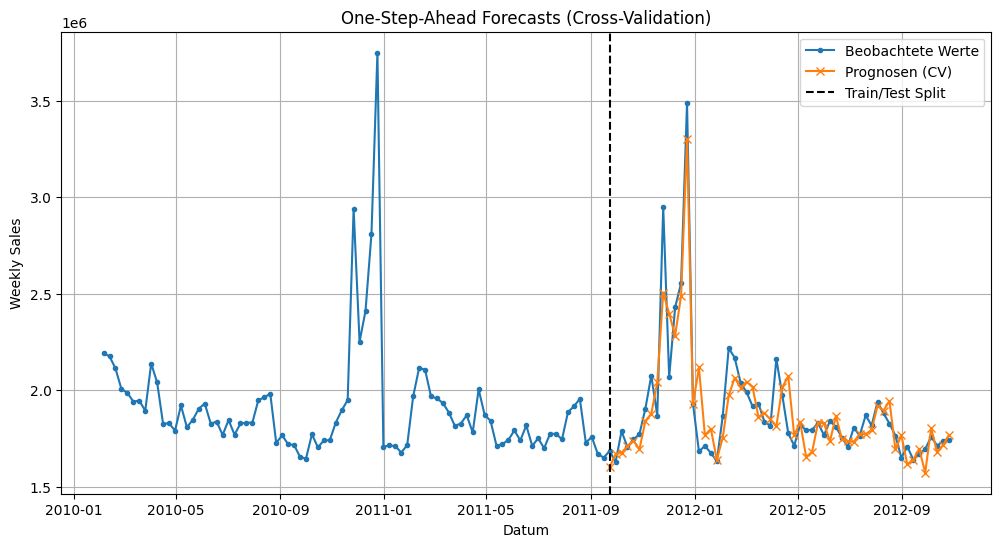

In [288]:
if model_type == 'SARIMA':
    cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
if model_type == 'Naive':
    cv_df = cross_validation_naive(sales)


Korrelations Tests

0      83823.56
1     -41383.39
2     112050.22
3      -6353.69
4       7060.20
5      78329.08
6      64203.39
7     197233.62
8    -171285.47
9     443535.55
10   -329181.83
11    145669.30
12     66139.49
13    187513.21
14      3250.59
15   -434828.73
16    -55185.56
17   -124376.95
18     -8528.13
19    113038.74
20    245537.35
21    104577.78
22     25211.19
23    -54080.95
24   -100303.01
25     69264.14
26    -44554.42
27    -34745.57
28    350079.29
29    -41142.12
30   -294454.11
31    -53241.37
32    -13484.49
33    136421.59
34    115480.65
35     -1885.84
36    -62423.18
37    105228.67
38    -54501.74
39      6240.95
40    -28932.18
41     73614.90
42     -8908.24
43     97663.51
44     22926.81
45     19999.17
46    -14797.45
47   -116292.53
48     71366.92
49   -116616.49
50     92349.57
51      -435.56
52    -24389.11
53    122009.68
54    -44580.92
55     32916.18
56     18804.51
57    -25015.38
Name: error, dtype: float64
Box Pierce Test: 0.0047
Ljung Box Test: 0.00

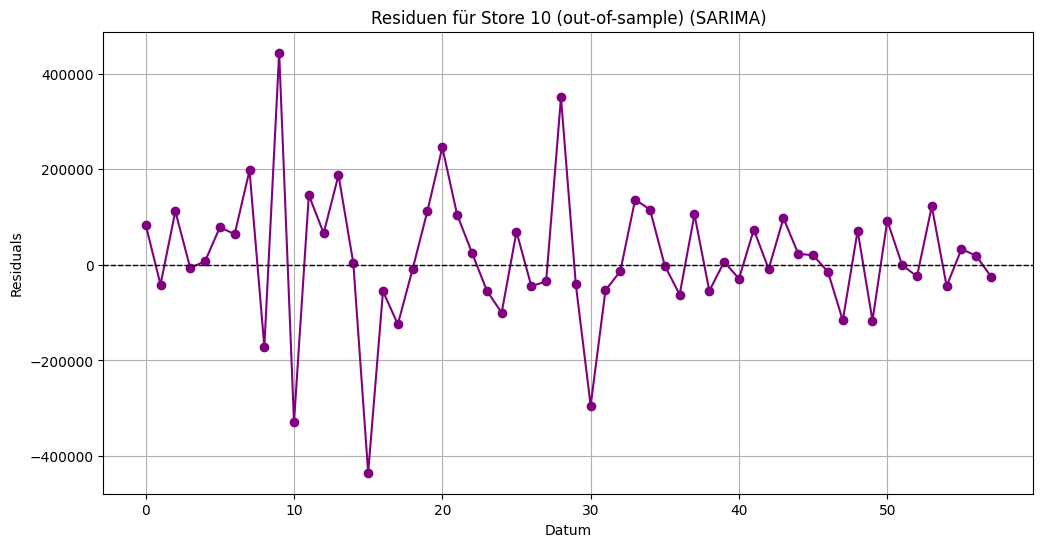

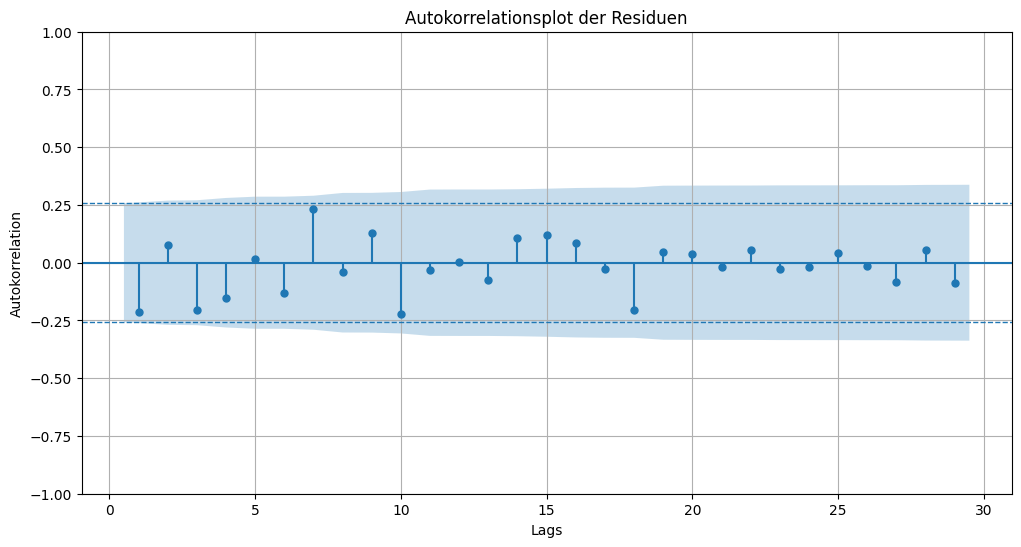

In [289]:
errors = cv_df['error']
print(errors)
box_pierce_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = errors, store_num = store_number, model = model_type, m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "acf", m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "pacf", m = 21)
pena_rodriguez_test_mc(residuals = errors)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29) #TODO: Gleich wie in-sample?
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)


run_test(residuals = errors)

durbin_watson_test(residuals = errors)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(errors, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (out-of-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()


acf_resid_plot(residuals = errors)


Mittelwert Tests

Mittelwert der Errors: 15614.334647536234
T-Test: 0.3969
Wilcoxon Test: 0.2699
Binomial Test: 0.8957
Kolmogorov Test: 0.0253


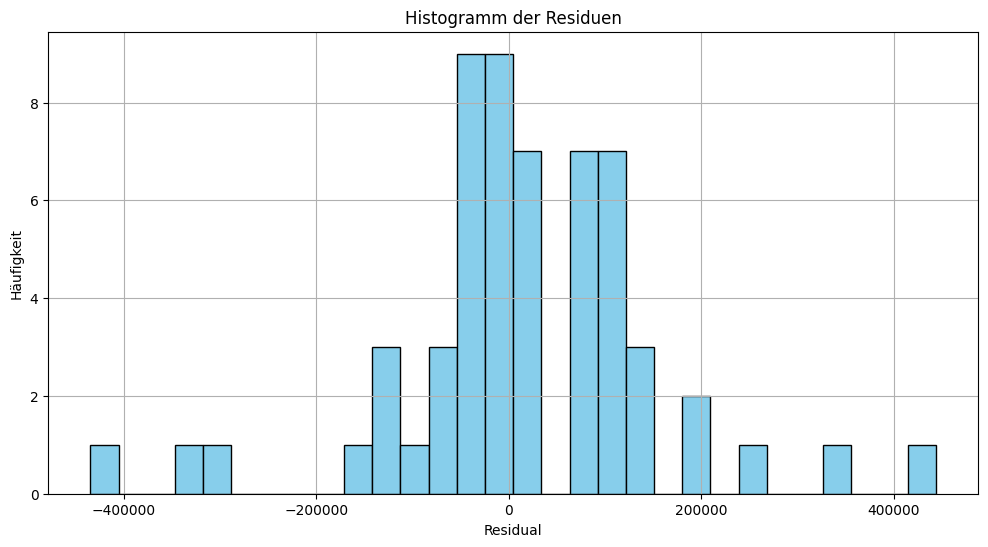

In [290]:
print(f'Mittelwert der Errors: {errors.mean()}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)

hist_plot(errors)


SMAPE

In [291]:
actual_values = cv_df['actual']
forecast_values = cv_df['forecast']

numerator = np.abs(forecast_values - actual_values)
denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 4.83%
